# Project Title: Analyzing Voting Patterns Using Clustering

## Introduction
In this project, we analyze voting patterns from a dataset of legislators using clustering techniques. The goal is to discover patterns in how different legislators vote on various bills and explore potential clusters of voting behavior.

The dataset contains information about votes, people, and roll calls from US legislation.

---

## Step 1: Loading the Data

We start by loading the necessary datasets: `bills.csv`, `people.csv`, `rollcalls.csv`, and `votes.csv`.


In [1]:
# Importing necessary libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import plotly.express as px

# Function to load data
def load_data():
    """Loads CSV files into pandas DataFrames."""
    bills_df = pd.read_csv('bills.csv')
    people_df = pd.read_csv('people.csv')
    rollcalls_df = pd.read_csv('rollcalls.csv')
    votes_df = pd.read_csv('votes.csv')
    return bills_df, people_df, rollcalls_df, votes_df

# Load datasets
bills_df, people_df, rollcalls_df, votes_df = load_data()

# Display the first few rows of the datasets
bills_df.head(), people_df.head(), rollcalls_df.head(), votes_df.head()


(   bill_id  session_id bill_number  status status_desc status_date  \
 0   668415        1156         HB1       1  Introduced  2015-01-06   
 1   668445        1156         HB2       4      Passed  2015-04-16   
 2   668091        1156         HB3       2   Engrossed  2015-01-12   
 3   668563        1156         HB4       1  Introduced  2015-01-06   
 4   668808        1156         HB5       2   Engrossed  2015-07-13   
 
                                                title  \
 0                          Reserved for the Speaker.   
 1  Medicare Access and CHIP Reauthorization Act o...   
 2                           Keystone XL Pipeline Act   
 3                          Reserved for the Speaker.   
 4                                Student Success Act   
 
                                          description  committee_id committee  \
 0                          Reserved for the Speaker.             0       NaN   
 1  Medicare Access and CHIP Reauthorization Act o...             

## Step 2: Creating the Vote Matrix

Next, we merge the votes and people data to create a vote matrix. Each row corresponds to a legislator, and each column represents a roll call vote.


In [2]:
# Function to merge and create a vote matrix
def create_vote_matrix(votes_df, people_df):
    """Merges votes and people data to create a vote matrix."""
    merged_votes_df = pd.merge(votes_df, people_df, on='people_id', how='left')
    vote_matrix = merged_votes_df.pivot(index='people_id', columns='roll_call_id', values='vote_desc')
    vote_matrix.fillna('Not Voted', inplace=True)
    return vote_matrix

# Create the vote matrix
vote_matrix = create_vote_matrix(votes_df, people_df)

# Display the first few rows of the vote matrix
vote_matrix.head()


roll_call_id,383926,383927,383928,383929,383945,383946,383947,383948,383957,383958,...,566112,566113,566117,566118,566119,566122,566132,566136,566137,566139
people_id,,,,,,,,,,,,,,,,,,,,,
8952,Not Voted,Not Voted,Not Voted,Not Voted,Yea,Not Voted,Nay,Yea,Yea,Nay,...,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted
8955,Not Voted,Not Voted,Not Voted,Not Voted,Yea,Not Voted,Nay,Yea,Yea,Nay,...,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted
8957,Nay,Nay,Yea,Nay,Yea,Yea,Nay,Yea,Yea,Nay,...,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted
8962,Nay,Nay,Yea,NV,Yea,Yea,Nay,Yea,Yea,Nay,...,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted
8963,Nay,Nay,Yea,Nay,Yea,Yea,Nay,Yea,Yea,Nay,...,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted,Not Voted


## Step 3: Preprocessing the Vote Matrix for Clustering

We need to convert the categorical vote descriptions into numerical values to apply clustering techniques.


In [3]:
# Function to preprocess vote matrix for clustering
def preprocess_vote_matrix(vote_matrix):
    """Converts categorical vote descriptions to numerical values."""
    le = LabelEncoder()
    vote_matrix_numerical = vote_matrix.apply(le.fit_transform)
    return vote_matrix_numerical

# Preprocess the vote matrix
vote_matrix_numerical = preprocess_vote_matrix(vote_matrix)

# Display the preprocessed vote matrix
vote_matrix_numerical.head()


roll_call_id,383926,383927,383928,383929,383945,383946,383947,383948,383957,383958,...,566112,566113,566117,566118,566119,566122,566132,566136,566137,566139
people_id,,,,,,,,,,,,,,,,,,,,,
8952,2,2,2,2,3,1,1,3,3,1,...,2,2,2,2,2,2,2,2,2,2
8955,2,2,2,2,3,1,1,3,3,1,...,2,2,2,2,2,2,2,2,2,2
8957,1,1,3,1,3,2,1,3,3,1,...,2,2,2,2,2,2,2,2,2,2
8962,1,1,3,0,3,2,1,3,3,1,...,2,2,2,2,2,2,2,2,2,2
8963,1,1,3,1,3,2,1,3,3,1,...,2,2,2,2,2,2,2,2,2,2


## Step 4: Performing K-Means Clustering

We use K-Means clustering to group legislators based on their voting patterns. The goal is to discover potential clusters that exhibit similar voting behavior.


In [4]:
# Function to perform K-means clustering
def perform_clustering(vote_matrix_numerical, n_clusters=5):
    """Performs K-means clustering and returns the clusters."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(vote_matrix_numerical)
    vote_matrix_numerical['Cluster'] = clusters + 1  # Adjust cluster labels to start from 1
    return vote_matrix_numerical

# Perform clustering
vote_matrix_numerical = perform_clustering(vote_matrix_numerical)

# Display the vote matrix with clusters
vote_matrix_numerical.head()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


roll_call_id,383926,383927,383928,383929,383945,383946,383947,383948,383957,383958,...,566113,566117,566118,566119,566122,566132,566136,566137,566139,Cluster
people_id,,,,,,,,,,,,,,,,,,,,,
8952,2,2,2,2,3,1,1,3,3,1,...,2,2,2,2,2,2,2,2,2,3
8955,2,2,2,2,3,1,1,3,3,1,...,2,2,2,2,2,2,2,2,2,3
8957,1,1,3,1,3,2,1,3,3,1,...,2,2,2,2,2,2,2,2,2,3
8962,1,1,3,0,3,2,1,3,3,1,...,2,2,2,2,2,2,2,2,2,3
8963,1,1,3,1,3,2,1,3,3,1,...,2,2,2,2,2,2,2,2,2,3


## Step 5: Bar Chart of Cluster Distribution

Now, we visualize the distribution of legislators across the different clusters using a bar chart.


<ipython-input-5-c2831f56aa89>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Set2')


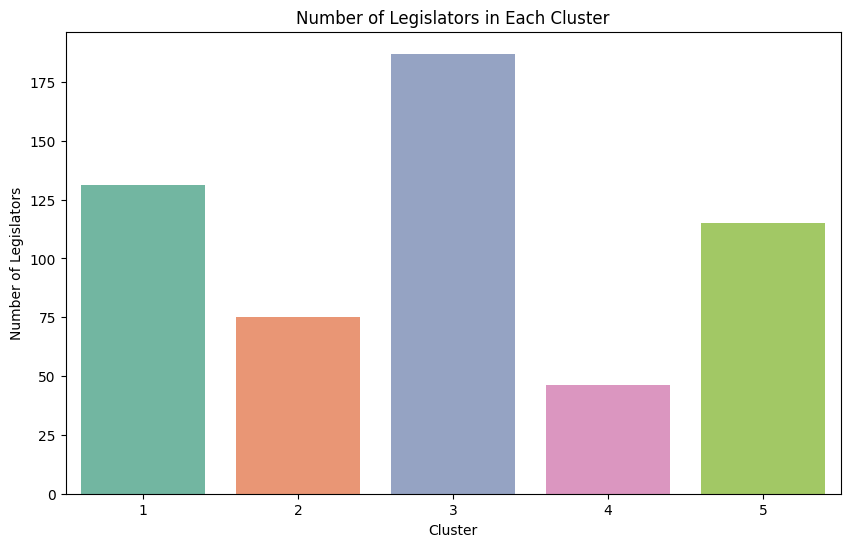

In [5]:
# Function to plot cluster distribution as a bar chart
def plot_cluster_distribution(people_with_clusters):
    """Plots a bar chart showing the distribution of legislators across clusters."""
    cluster_counts = people_with_clusters['Cluster'].value_counts()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Set2')
    plt.title('Number of Legislators in Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Legislators')
    plt.show()

# Merge people with clusters and plot distribution
people_with_clusters = pd.merge(people_df[['people_id', 'name']], vote_matrix_numerical[['Cluster']], on='people_id')
plot_cluster_distribution(people_with_clusters)


## Step 6: Party Distribution in Each Cluster

We can also visualize the distribution of party affiliation (Democrat, Republican, Independent) in each cluster.


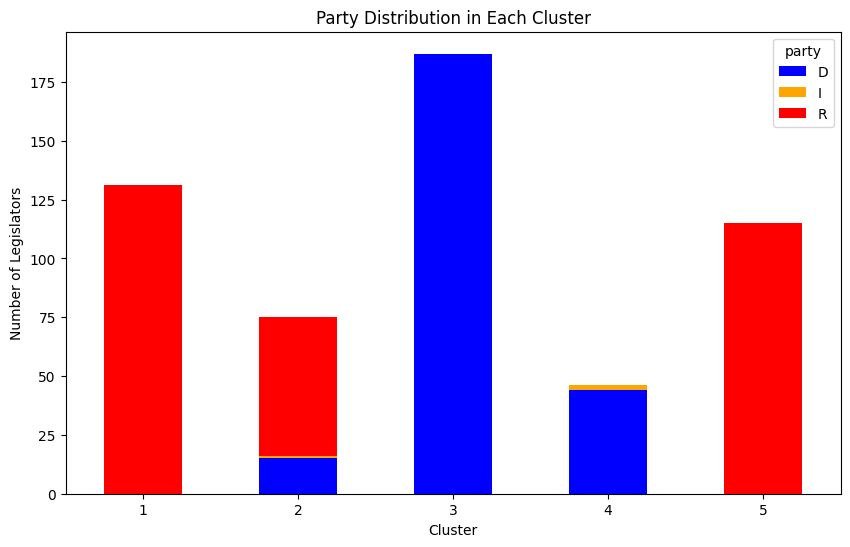

In [6]:
# Function to visualize party distribution in each cluster
def visualize_party_distribution_in_clusters(people_with_clusters_party):
    """Creates a bar plot showing the party distribution in each cluster."""
    party_counts_in_clusters = people_with_clusters_party.groupby(['Cluster', 'party']).size().unstack().fillna(0)
    party_colors = {'R': 'red', 'D': 'blue', 'I': 'orange'}

    party_counts_in_clusters.plot(kind='bar', stacked=True, figsize=(10, 6),
                                  color=[party_colors.get(x, '#333333') for x in party_counts_in_clusters.columns])

    plt.title('Party Distribution in Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Legislators')
    plt.xticks(rotation=0)
    plt.show()

# Merge party information and visualize party distribution
people_with_clusters_party = pd.merge(people_with_clusters, people_df[['people_id', 'party']], on='people_id')
visualize_party_distribution_in_clusters(people_with_clusters_party)


## Step 7: Heatmap of Voting Patterns

This heatmap shows the **average voting behavior** of legislators, grouped into clusters, across various roll call votes. Each row represents a cluster of legislators, and each column corresponds to a specific vote. The colors indicate how the legislators in each cluster voted:

- **Blue** indicates opposition.
- **Red** indicates support.
- **Orange/Peach** reflects mixed or neutral voting behavior.

#### Key Takeaways:
- **Consistent Voting**: **Cluster 3** shows highly consistent voting patterns across most votes, suggesting strong alignment among these legislators.
- **Mixed Behavior**: **Clusters 1 and 5** show more variability in voting behavior, reflecting a diverse range of opinions on certain issues.
- **Polarizing Votes**: Some votes show distinct color differences between clusters, indicating a division in voting behavior across groups of legislators.
- **Aligned Votes**: In other votes, the colors are more uniform across clusters, suggesting broader consensus among the groups.

#### Interpretation:
This heatmap helps us quickly understand which groups of legislators vote similarly and highlights where they align or diverge on key issues. It provides useful insights into potential voting blocs, areas of consensus, and political divisions.


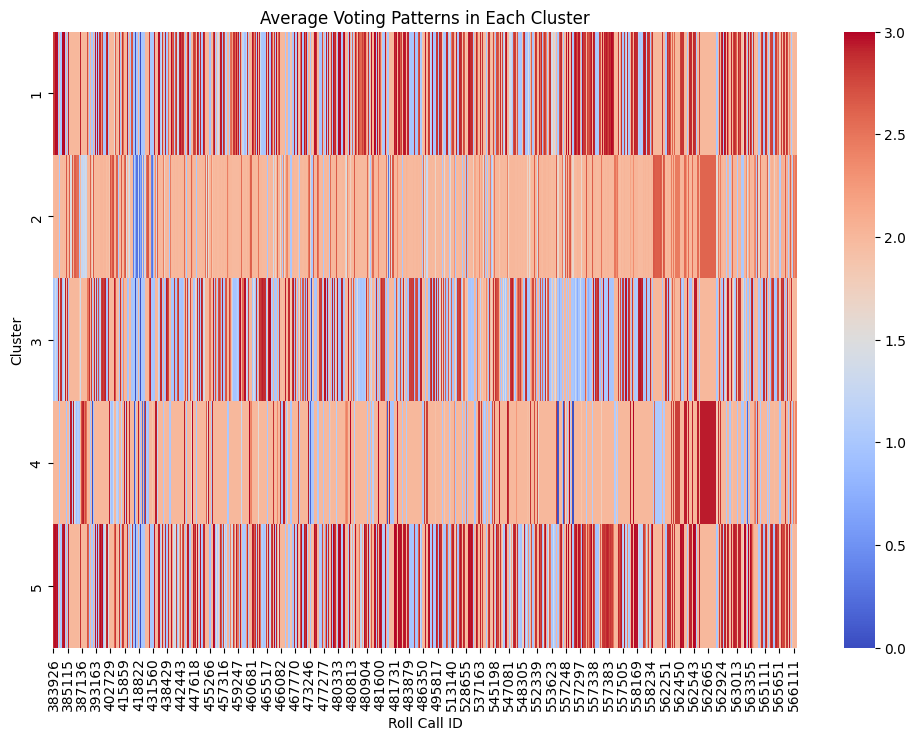

In [7]:
# Function to plot heatmap of voting patterns
def plot_heatmap(vote_matrix_numerical):
    """Creates a heatmap representing the average voting patterns within each cluster."""
    cluster_means = vote_matrix_numerical.groupby('Cluster').mean()

    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_means, cmap='coolwarm', annot=False)
    plt.title('Average Voting Patterns in Each Cluster')
    plt.xlabel('Roll Call ID')
    plt.ylabel('Cluster')
    plt.show()

# Plot heatmap of voting patterns
plot_heatmap(vote_matrix_numerical)


## Step 8: Visualizing Clusters Using t-SNE

To further explore the clustering results, we use t-SNE (t-distributed Stochastic Neighbor Embedding), a popular dimensionality reduction technique.

t-SNE allows us to project high-dimensional voting data into a two-dimensional space, making it easier to visualize and interpret the clusters. Each point in the plot represents a legislator, and the color indicates the cluster to which the legislator belongs. The goal of this visualization is to show how well-separated or cohesive the clusters are in the reduced space.

Although t-SNE is effective for visualization, it should be noted that it does not preserve distances perfectly, so it's best used for exploring clusters, rather than exact quantitative analysis.

### t-SNE Visualization Interpretation:

This **t-SNE plot** shows the clustering of legislators based on their voting patterns. Each point in the plot represents a legislator, and the color corresponds to the cluster that the legislator belongs to (Cluster 1 through Cluster 5). The t-SNE algorithm reduces the high-dimensional voting data to a 2D space, which helps visualize the relationships between the clusters.

#### Key Observations:

1. **Cluster Separation**:
   - **Cluster 1 (Red)** and **Cluster 4 (Purple)** overlap slightly but are mostly distinct, which suggests that while the legislators in these two clusters have some similar voting patterns, there are still enough differences to separate them.
   - **Cluster 2 (Blue)** and **Cluster 5 (Orange)** are close together, but there is a clear boundary between them, indicating that while these legislators share some voting patterns, they differ on certain issues.
   - **Cluster 3 (Green)** is well-separated from all the other clusters, indicating that legislators in this group have very distinct voting patterns from the rest.

2. **Tight Clusters**:
   - **Cluster 3 (Green)** forms a tight group, suggesting that the legislators within this cluster vote very similarly on most issues.
   - **Cluster 2 (Blue)** and **Cluster 5 (Orange)** also show tight groupings, indicating strong voting cohesion within these clusters.

3. **Overlapping/Close Clusters**:
   - The slight overlap between **Cluster 1 (Red)** and **Cluster 4 (Purple)** suggests that there might be some legislators with similar voting patterns across these clusters, leading to potential ambiguity between them.
   - The proximity of **Cluster 2 (Blue)** and **Cluster 5 (Orange)** suggests that these legislators might have similar voting behavior but still differ enough to form separate clusters.

4. **Isolated Clusters**:
   - **Cluster 3 (Green)** is isolated from the rest of the clusters, indicating that legislators in this group have unique voting patterns that set them apart from the other groups.

#### General Interpretation:
The t-SNE plot reveals the clear separation of clusters, showing which groups of legislators vote similarly and which are distinct. The tightness of some clusters indicates cohesive voting patterns within those groups, while the separation between clusters highlights the distinctiveness of their voting behaviors.

This visualization helps viewers quickly understand the relationships between groups of legislators based on their voting behavior, and it provides insight into potential alliances or divisions among them.


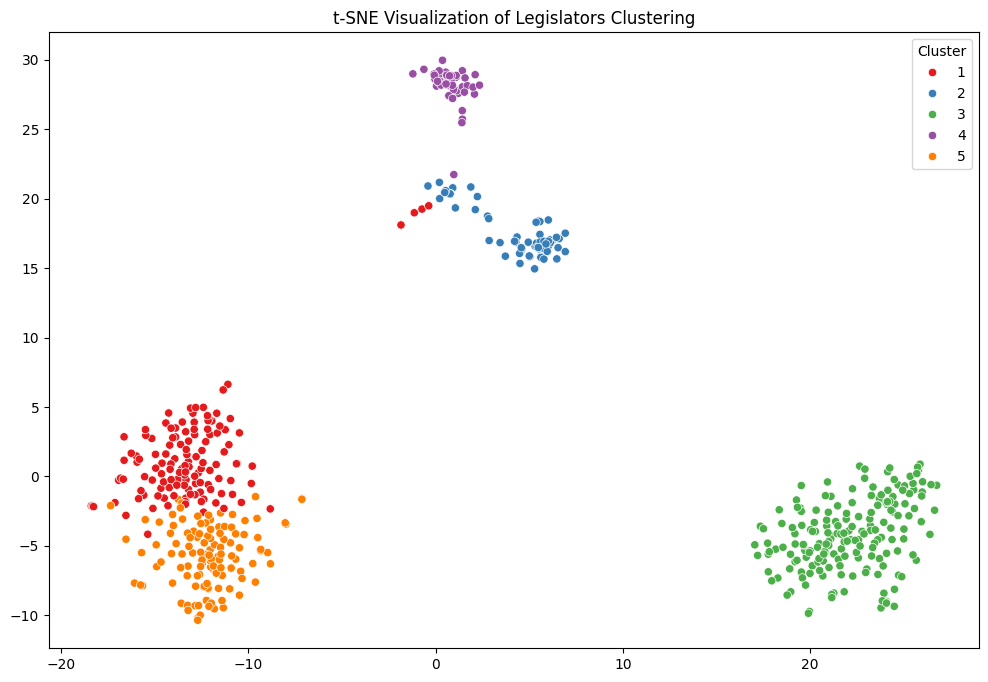

In [8]:
# Function to visualize clusters using t-SNE
def visualize_tsne(vote_matrix_numerical, title='t-SNE Visualization of Legislators Clustering'):
    """Creates a t-SNE scatter plot for visualizing clusters."""
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(vote_matrix_numerical.drop('Cluster', axis=1))

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=vote_matrix_numerical['Cluster'], palette='Set1')
    plt.title(title)
    plt.show()

# Visualize the clusters
visualize_tsne(vote_matrix_numerical)


## Step 9: Analyzing Voting Patterns by District

In this step, we analyze the **similarity** or **variation** in voting patterns within each district. We begin by merging the voting data with the district information, allowing us to group legislators by their districts. After that, we calculate the **standard deviation** of voting patterns for each district:

- A **lower standard deviation** indicates that legislators within a district tend to vote more consistently with each other.
- A **higher standard deviation** suggests greater variability in voting behaviors within the district.

Additionally, we check for missing district information after merging to ensure that no critical data is missing that could affect the results of our analysis.

This analysis helps us understand whether legislators from the same district tend to vote in a unified manner or if there are significant differences in their voting behavior. It provides insight into whether districts show cohesive voting tendencies or diverse political representation.


In [9]:
# Check for missing values after merging people_with_clusters_party and people_df
merged_data = pd.merge(people_with_clusters_party[['people_id', 'Cluster']],
                       people_df[['people_id', 'district']],
                       on='people_id')

# Check for missing districts after the merge
missing_after_merge = merged_data['district'].isna().sum()
print(f"Number of missing districts after merging: {missing_after_merge}")


Number of missing districts after merging: 0


In [10]:
def analyze_district_voting_patterns(people_with_clusters_party, people_df, vote_matrix_numerical):
    """
    Analyzes voting patterns by district and calculates the similarity of voting patterns within each district.
    Fills NaN values with zeros for districts with insufficient data.

    Args:
        people_with_clusters_party (pd.DataFrame): DataFrame containing people with cluster and party information.
        people_df (pd.DataFrame): DataFrame containing additional details about people, including district.
        vote_matrix_numerical (pd.DataFrame): Numerical vote matrix with voting patterns and clusters.

    Returns:
        pd.Series: Series showing the standard deviation of voting patterns for each district, sorted by similarity.
    """
    # Step 1: Merge people, district, and voting data
    people_with_districts = pd.merge(people_with_clusters_party[['people_id', 'Cluster']],
                                     people_df[['people_id', 'district']],
                                     on='people_id')

    # Step 2: Merge with the vote matrix to include voting behavior
    voting_data_with_districts = pd.merge(people_with_districts, vote_matrix_numerical.drop('Cluster', axis=1),
                                          on='people_id')

    # Step 3: Group by district and calculate both mean and standard deviation for voting behavior
    district_voting_stats = voting_data_with_districts.groupby('district').agg(['mean', 'std'])

    # Step 4: Extract the standard deviation part and handle NaNs (fill with 0)
    district_vote_similarity = district_voting_stats.loc[:, (slice(None), 'std')].mean(axis=1).fillna(0).sort_values()

    return district_vote_similarity

# Example usage:
district_vote_similarity = analyze_district_voting_patterns(people_with_clusters_party, people_df, vote_matrix_numerical)
district_vote_similarity  # Display districts with the most similar voting patterns


,0
district,
HD-AK,0.000000
HD-OH-6,0.000000
HD-OH-5,0.000000
HD-OH-4,0.000000
HD-OH-3,0.000000
...,...
HD-WV-2,3.165595
HD-IL-18,3.212218
HD-MI-14,3.214582


## Step 10: Dendrogram Visualization

In this step, we use a dendrogram to explore the hierarchical structure of the voting pattern similarities across districts. A dendrogram is a tree-like diagram that illustrates the arrangement of the clusters produced by hierarchical clustering.

Each branch of the dendrogram represents a district, and the height at which two branches join reflects the distance (or dissimilarity) between those districts in terms of their voting patterns. Districts that merge at lower heights have more similar voting behaviors, while those that merge at higher heights are more dissimilar.

We truncate the dendrogram to focus on the most important clusters, making it easier to interpret the relationships between districts. This visualization helps us understand the hierarchical relationships between districts and explore how voting patterns group together at different levels of similarity.

### Dendrogram Interpretation:

This dendrogram visualizes the **hierarchical clustering of districts** based on the similarity of their voting patterns. The height of the branches represents the **distance** or **dissimilarity** between the voting behaviors of different districts.

#### Key Observations:

1. **Clusters**:
   - The dendrogram groups districts that have similar voting patterns into clusters. The districts at the bottom are more similar to each other, while districts that are joined at higher levels are more dissimilar.
   - **Short branches** at the bottom indicate districts with very similar voting patterns. For example, **HD-KY-1** and **HD-PA-2** have short branches, suggesting that these districts vote very similarly.

2. **Large Distance Between Groups**:
   - The blue line at the top divides the dendrogram into two major groups. The **left group (orange)** and the **right group (green)** are relatively far apart, indicating that these two sets of districts have significantly different voting patterns.
   - The orange group includes districts like **HD-KY-1**, **HD-PA-2**, and **HD-HI-2**, which vote more similarly to each other than they do to districts in the green group.
   - The green group includes districts like **SD-NE**, **SD-UT**, and **SD-ND**, which share more voting similarities among themselves but differ from those in the orange group.

3. **Height of Branches**:
   - The vertical distance (height) between where branches join reflects how different the voting behaviors are between the groups. For instance, **SD-ND** and **SD-UT** join at a lower height, suggesting that they are more similar in voting behavior compared to, say, **HD-KY-1** and **SD-ND**, which join at a much higher point.
   - The higher the branch point, the greater the difference in voting patterns between the districts.

4. **Interpretation of Specific Districts**:
   - Districts that join earlier (closer to the bottom) have highly similar voting patterns, while districts that are connected only at higher levels are more distinct from one another.
   - For instance, districts like **HD-KY-1**, **HD-PA-2**, and **HD-HI-2** form a tight cluster, indicating that legislators from these districts tend to vote similarly on many issues.
   - On the other hand, districts such as **SD-NE** and **SD-NV** form a separate cluster, showing that legislators from these areas vote in a similar manner, but distinctly different from the districts in the orange group.

#### General Interpretation:
The dendrogram reveals the hierarchical structure of voting pattern similarities between districts. The closer the branches are at the bottom, the more similar the voting behaviors. The two major groups (orange and green) show two distinct sets of voting behaviors across the districts. This hierarchical clustering helps identify how groups of districts align or diverge in their voting patterns, providing insight into regional or ideological voting blocs.


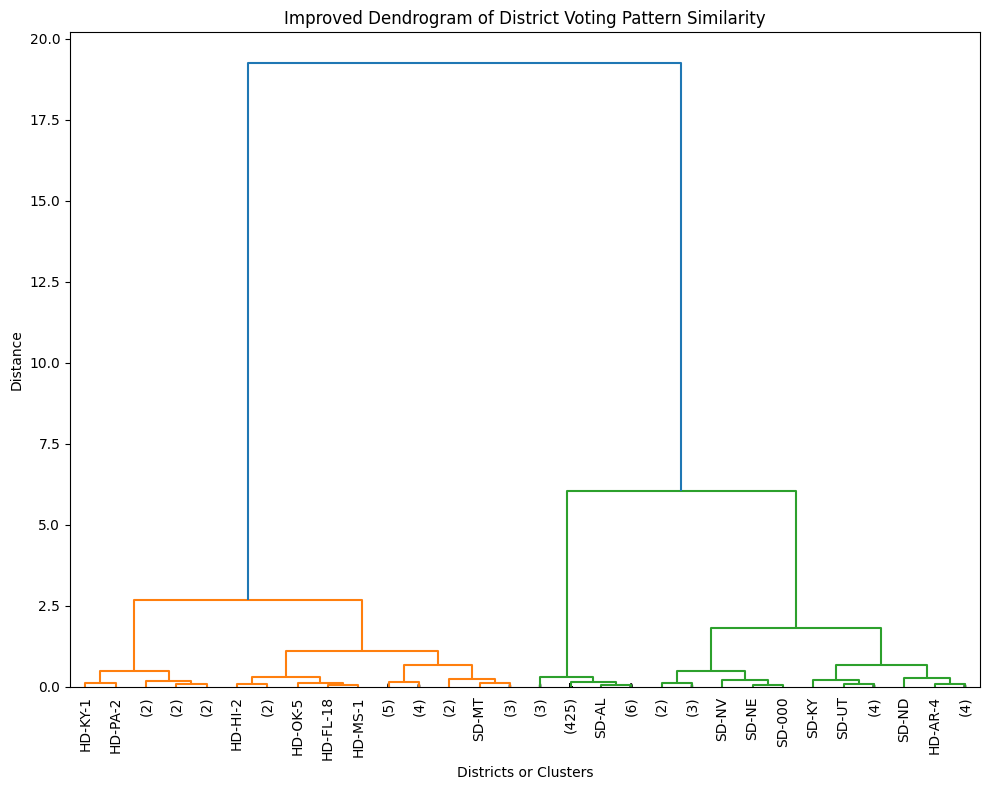

In [11]:
# Function to plot an improved dendrogram for district voting patterns
def plot_improved_dendrogram(district_vote_similarity, truncate_mode='lastp', p=30):
    """Plots an improved dendrogram with truncated view for better readability."""
    Z = linkage(district_vote_similarity.values.reshape(-1, 1), method='ward')

    plt.figure(figsize=(10, 8))
    dendrogram(Z, labels=district_vote_similarity.index, truncate_mode=truncate_mode, p=p,
               leaf_rotation=90, leaf_font_size=10, show_contracted=True)
    plt.title('Improved Dendrogram of District Voting Pattern Similarity')
    plt.xlabel('Districts or Clusters')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

# Example usage of dendrogram
plot_improved_dendrogram(district_vote_similarity)
